First I import necessary libraries and tools.\
briefly:\
**matplot** for figures\
**torch** for neural network implement\
**numpy** and **pandas** for numerical and data analysis.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.1+cu116  Device: cuda


I Defined the transform to convert the images to PyTorch tensors and normalize the pixel values \
So, I split my data set into 2 sections \
first a train data set consist of 112000 samples \
second a test data set consist of 18000 samples \
in this cell I set batch size to 32

In [2]:

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))]) 

train_dataset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=True, 
                                        download=True, transform=transform) 

test_dataset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=False, 
                                       download=True, transform=transform) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, 
                                          shuffle=True, num_workers=2) 

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, 
                                         shuffle=False, num_workers=2)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


As you see batch size is 32 and pics are 28*28 pixels

In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Let's check some of our classes!

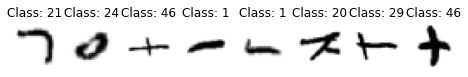

In [4]:
pltsize=1
plt.figure(figsize=(8*pltsize, pltsize))

for i in range(8):
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

Now it's time to implement neural network

Dropout equals to 0.2

I used Sigmoid as activation function

learning rate equals to 0.05

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(196, 98)
        self.fc2_drop = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(98, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=196, out_features=98, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=98, out_features=47, bias=True)
)


In this two cells I set my model for training and testing

In [6]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [7]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

I set epochs 20 and getting the result

In [8]:
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.849631
Train Epoch: 1 [6400/112800 (6%)]	Loss: 2.084817
Train Epoch: 1 [12800/112800 (11%)]	Loss: 2.031525
Train Epoch: 1 [19200/112800 (17%)]	Loss: 1.401667
Train Epoch: 1 [25600/112800 (23%)]	Loss: 1.418348
Train Epoch: 1 [32000/112800 (28%)]	Loss: 0.812708
Train Epoch: 1 [38400/112800 (34%)]	Loss: 1.040762
Train Epoch: 1 [44800/112800 (40%)]	Loss: 1.225957
Train Epoch: 1 [51200/112800 (45%)]	Loss: 1.493537
Train Epoch: 1 [57600/112800 (51%)]	Loss: 0.952832
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.803513
Train Epoch: 1 [70400/112800 (62%)]	Loss: 1.454389
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.924784
Train Epoch: 1 [83200/112800 (74%)]	Loss: 0.934070
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.898542
Train Epoch: 1 [96000/112800 (85%)]	Loss: 1.231033
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.909905
Train Epoch: 1 [108800/112800 (96%)]	Loss: 0.953644

Test dataset: Average loss: 0.8069, Accuracy: 13923/18800 (74%)

Train Epoch: 2 [0/112

Figure for Test loss and Test Accuracy

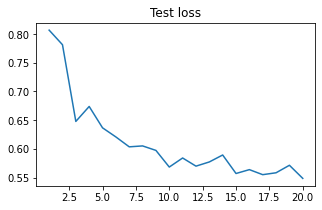

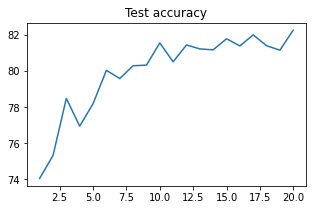

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 2 , batch size = 32 , Dropout  = 0.2, Epochs = 10

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(196, 98)
        self.fc2_drop = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(98, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=196, out_features=98, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=98, out_features=47, bias=True)
)


In [11]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [12]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [13]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.832587
Train Epoch: 1 [6400/112800 (6%)]	Loss: 2.186140
Train Epoch: 1 [12800/112800 (11%)]	Loss: 1.692483
Train Epoch: 1 [19200/112800 (17%)]	Loss: 1.342576
Train Epoch: 1 [25600/112800 (23%)]	Loss: 1.424643
Train Epoch: 1 [32000/112800 (28%)]	Loss: 1.112538
Train Epoch: 1 [38400/112800 (34%)]	Loss: 1.416893
Train Epoch: 1 [44800/112800 (40%)]	Loss: 1.254518
Train Epoch: 1 [51200/112800 (45%)]	Loss: 1.096008
Train Epoch: 1 [57600/112800 (51%)]	Loss: 0.915029
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.828300
Train Epoch: 1 [70400/112800 (62%)]	Loss: 1.611903
Train Epoch: 1 [76800/112800 (68%)]	Loss: 1.708751
Train Epoch: 1 [83200/112800 (74%)]	Loss: 1.185145
Train Epoch: 1 [89600/112800 (79%)]	Loss: 1.121686
Train Epoch: 1 [96000/112800 (85%)]	Loss: 1.098791
Train Epoch: 1 [102400/112800 (91%)]	Loss: 1.125882
Train Epoch: 1 [108800/112800 (96%)]	Loss: 0.813338

Test dataset: Average loss: 0.7799, Accuracy: 14076/18800 (75%)

Train Epoch: 2 [0/112

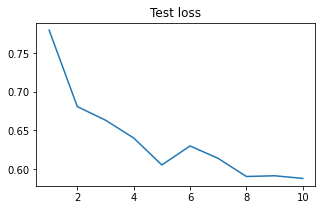

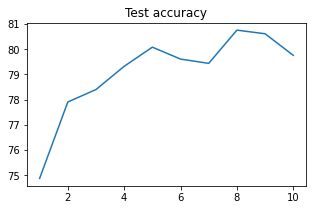

In [14]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 2 , batch size = 32 , Dropout  = 0, Epochs = 20

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0)
        
        self.fc2 = nn.Linear(196, 98)
        self.fc2_drop = nn.Dropout(0)
        
        self.fc3 = nn.Linear(98, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0, inplace=False)
  (fc2): Linear(in_features=196, out_features=98, bias=True)
  (fc2_drop): Dropout(p=0, inplace=False)
  (fc3): Linear(in_features=98, out_features=47, bias=True)
)


In [16]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [17]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [18]:
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.836694
Train Epoch: 1 [6400/112800 (6%)]	Loss: 1.880280
Train Epoch: 1 [12800/112800 (11%)]	Loss: 1.289073
Train Epoch: 1 [19200/112800 (17%)]	Loss: 1.202512
Train Epoch: 1 [25600/112800 (23%)]	Loss: 1.367987
Train Epoch: 1 [32000/112800 (28%)]	Loss: 1.170112
Train Epoch: 1 [38400/112800 (34%)]	Loss: 1.058307
Train Epoch: 1 [44800/112800 (40%)]	Loss: 0.763578
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.994858
Train Epoch: 1 [57600/112800 (51%)]	Loss: 0.745701
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.726194
Train Epoch: 1 [70400/112800 (62%)]	Loss: 0.688094
Train Epoch: 1 [76800/112800 (68%)]	Loss: 1.047003
Train Epoch: 1 [83200/112800 (74%)]	Loss: 0.743992
Train Epoch: 1 [89600/112800 (79%)]	Loss: 1.357917
Train Epoch: 1 [96000/112800 (85%)]	Loss: 1.347736
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.819784
Train Epoch: 1 [108800/112800 (96%)]	Loss: 0.795607

Test dataset: Average loss: 0.7534, Accuracy: 14371/18800 (76%)

Train Epoch: 2 [0/112

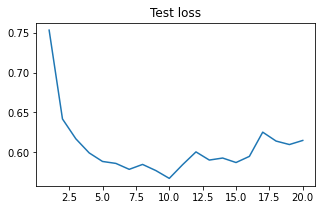

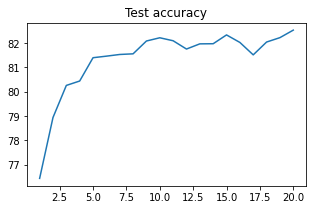

In [19]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 2 , batch size = 32 , Dropout  = 0, Epochs = 10

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0)
        
        self.fc2 = nn.Linear(196, 98)
        self.fc2_drop = nn.Dropout(0)
        
        self.fc3 = nn.Linear(98, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0, inplace=False)
  (fc2): Linear(in_features=196, out_features=98, bias=True)
  (fc2_drop): Dropout(p=0, inplace=False)
  (fc3): Linear(in_features=98, out_features=47, bias=True)
)


In [21]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [22]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [23]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.888734
Train Epoch: 1 [6400/112800 (6%)]	Loss: 1.676510
Train Epoch: 1 [12800/112800 (11%)]	Loss: 1.309459
Train Epoch: 1 [19200/112800 (17%)]	Loss: 1.275714
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.586707
Train Epoch: 1 [32000/112800 (28%)]	Loss: 0.893342
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.887974
Train Epoch: 1 [44800/112800 (40%)]	Loss: 0.704117
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.820554
Train Epoch: 1 [57600/112800 (51%)]	Loss: 0.828433
Train Epoch: 1 [64000/112800 (57%)]	Loss: 1.085778
Train Epoch: 1 [70400/112800 (62%)]	Loss: 0.778429
Train Epoch: 1 [76800/112800 (68%)]	Loss: 1.134824
Train Epoch: 1 [83200/112800 (74%)]	Loss: 0.802017
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.534241
Train Epoch: 1 [96000/112800 (85%)]	Loss: 1.077912
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.998714
Train Epoch: 1 [108800/112800 (96%)]	Loss: 0.782416

Test dataset: Average loss: 0.7456, Accuracy: 14275/18800 (76%)

Train Epoch: 2 [0/112

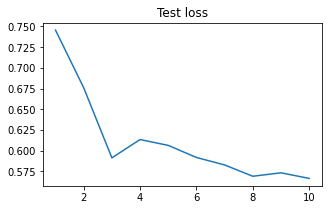

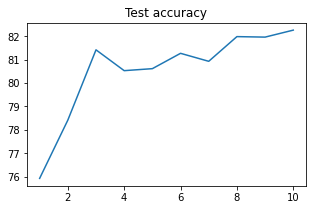

In [24]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 1 , batch size = 32 , Dropout  = 0.2, Epochs = 20

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0.2)
        
        
        self.fc2 = nn.Linear(196, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        return F.log_softmax(self.fc2(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=196, out_features=47, bias=True)
)


In [26]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [27]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [28]:
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.876226
Train Epoch: 1 [6400/112800 (6%)]	Loss: 2.124200
Train Epoch: 1 [12800/112800 (11%)]	Loss: 1.489906
Train Epoch: 1 [19200/112800 (17%)]	Loss: 1.444101
Train Epoch: 1 [25600/112800 (23%)]	Loss: 1.257966
Train Epoch: 1 [32000/112800 (28%)]	Loss: 1.203870
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.988456
Train Epoch: 1 [44800/112800 (40%)]	Loss: 1.145062
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.565442
Train Epoch: 1 [57600/112800 (51%)]	Loss: 0.965174
Train Epoch: 1 [64000/112800 (57%)]	Loss: 1.029752
Train Epoch: 1 [70400/112800 (62%)]	Loss: 1.057702
Train Epoch: 1 [76800/112800 (68%)]	Loss: 1.231354
Train Epoch: 1 [83200/112800 (74%)]	Loss: 1.211590
Train Epoch: 1 [89600/112800 (79%)]	Loss: 1.034884
Train Epoch: 1 [96000/112800 (85%)]	Loss: 0.793258
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.615852
Train Epoch: 1 [108800/112800 (96%)]	Loss: 1.009291

Test dataset: Average loss: 0.8293, Accuracy: 14120/18800 (75%)

Train Epoch: 2 [0/112

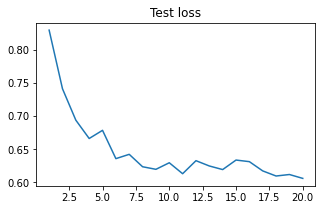

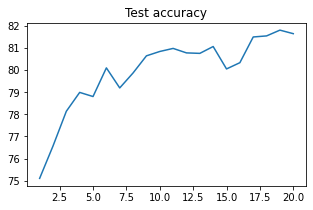

In [29]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 1 , batch size = 32 , Dropout  = 0.2, Epochs = 10

In [30]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 0.719743
Train Epoch: 1 [6400/112800 (6%)]	Loss: 0.633343
Train Epoch: 1 [12800/112800 (11%)]	Loss: 0.658248
Train Epoch: 1 [19200/112800 (17%)]	Loss: 0.618969
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.672299
Train Epoch: 1 [32000/112800 (28%)]	Loss: 0.818618
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.549493
Train Epoch: 1 [44800/112800 (40%)]	Loss: 0.528224
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.691468
Train Epoch: 1 [57600/112800 (51%)]	Loss: 0.480767
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.382288
Train Epoch: 1 [70400/112800 (62%)]	Loss: 1.031832
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.473767
Train Epoch: 1 [83200/112800 (74%)]	Loss: 0.519903
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.458428
Train Epoch: 1 [96000/112800 (85%)]	Loss: 0.405956
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.480815
Train Epoch: 1 [108800/112800 (96%)]	Loss: 0.541026

Test dataset: Average loss: 0.6013, Accuracy: 15259/18800 (81%)

Train Epoch: 2 [0/112

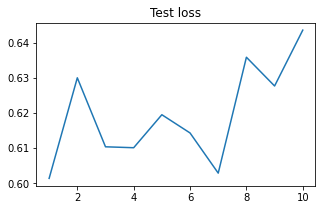

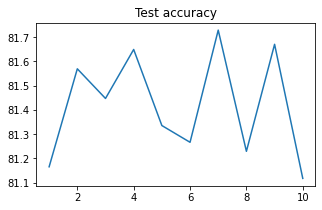

In [31]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 1 , batch size = 32 , Dropout  = 0, Epochs = 20



In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0)
        
        
        self.fc2 = nn.Linear(196, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        return F.log_softmax(self.fc2(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0, inplace=False)
  (fc2): Linear(in_features=196, out_features=47, bias=True)
)


In [33]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [34]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [35]:
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.827380
Train Epoch: 1 [6400/112800 (6%)]	Loss: 1.705333
Train Epoch: 1 [12800/112800 (11%)]	Loss: 1.111511
Train Epoch: 1 [19200/112800 (17%)]	Loss: 1.301828
Train Epoch: 1 [25600/112800 (23%)]	Loss: 1.130682
Train Epoch: 1 [32000/112800 (28%)]	Loss: 1.330156
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.567150
Train Epoch: 1 [44800/112800 (40%)]	Loss: 1.167530
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.907998
Train Epoch: 1 [57600/112800 (51%)]	Loss: 0.919643
Train Epoch: 1 [64000/112800 (57%)]	Loss: 1.691360
Train Epoch: 1 [70400/112800 (62%)]	Loss: 0.786440
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.709648
Train Epoch: 1 [83200/112800 (74%)]	Loss: 0.671966
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.725200
Train Epoch: 1 [96000/112800 (85%)]	Loss: 0.732703
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.708569
Train Epoch: 1 [108800/112800 (96%)]	Loss: 0.453908

Test dataset: Average loss: 0.8024, Accuracy: 14211/18800 (76%)

Train Epoch: 2 [0/112

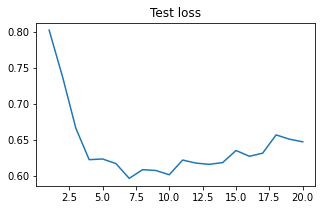

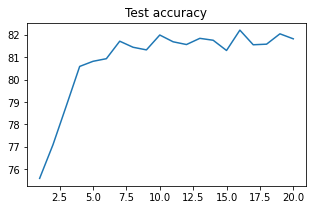

In [36]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 1 , batch size = 32 , Dropout  = 0, Epochs = 10

In [37]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 0.293709
Train Epoch: 1 [6400/112800 (6%)]	Loss: 0.141880
Train Epoch: 1 [12800/112800 (11%)]	Loss: 0.102194
Train Epoch: 1 [19200/112800 (17%)]	Loss: 0.233937
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.280481
Train Epoch: 1 [32000/112800 (28%)]	Loss: 0.181006
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.733103
Train Epoch: 1 [44800/112800 (40%)]	Loss: 0.199985
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.292212
Train Epoch: 1 [57600/112800 (51%)]	Loss: 0.423737
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.548099
Train Epoch: 1 [70400/112800 (62%)]	Loss: 0.309791
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.382603
Train Epoch: 1 [83200/112800 (74%)]	Loss: 0.572398
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.219754
Train Epoch: 1 [96000/112800 (85%)]	Loss: 0.410317
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.392249
Train Epoch: 1 [108800/112800 (96%)]	Loss: 0.358258

Test dataset: Average loss: 0.6752, Accuracy: 15223/18800 (81%)

Train Epoch: 2 [0/112

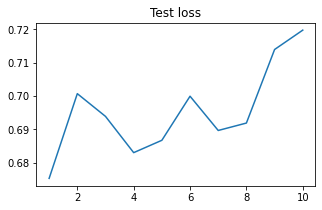

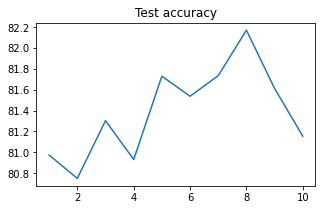

In [38]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 2 , batch size = 64 , Dropout  = 0.2, Epochs = 20

In [39]:

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))]) 

train_dataset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=True, 
                                        download=True, transform=transform) 

test_dataset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=False, 
                                       download=True, transform=transform) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                          shuffle=True, num_workers=2) 

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, 
                                         shuffle=False, num_workers=2)

In [40]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(196, 98)
        self.fc2_drop = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(98, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=196, out_features=98, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=98, out_features=47, bias=True)
)


In [42]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [43]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [44]:
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.851846
Train Epoch: 1 [12800/112800 (11%)]	Loss: 2.280796
Train Epoch: 1 [25600/112800 (23%)]	Loss: 1.784519
Train Epoch: 1 [38400/112800 (34%)]	Loss: 1.370062
Train Epoch: 1 [51200/112800 (45%)]	Loss: 1.047181
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.994170
Train Epoch: 1 [76800/112800 (68%)]	Loss: 1.148996
Train Epoch: 1 [89600/112800 (79%)]	Loss: 1.219784
Train Epoch: 1 [102400/112800 (91%)]	Loss: 1.268605

Test dataset: Average loss: 0.8433, Accuracy: 13852/18800 (74%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 1.035675
Train Epoch: 2 [12800/112800 (11%)]	Loss: 1.012474
Train Epoch: 2 [25600/112800 (23%)]	Loss: 0.886694
Train Epoch: 2 [38400/112800 (34%)]	Loss: 0.738463
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.737611
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.954220
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.740447
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.687390
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.872358

Test dataset: Average l

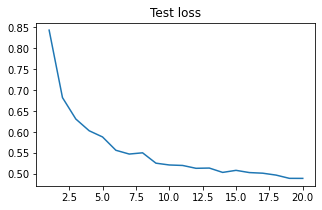

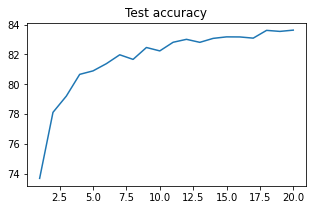

In [45]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 2 , batch size = 64 , Dropout  = 0.2, Epochs = 10

In [46]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 0.791468
Train Epoch: 1 [12800/112800 (11%)]	Loss: 0.623524
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.683046
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.661914
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.498374
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.547728
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.287007
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.453140
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.487026

Test dataset: Average loss: 0.4868, Accuracy: 15713/18800 (84%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 0.622713
Train Epoch: 2 [12800/112800 (11%)]	Loss: 0.711150
Train Epoch: 2 [25600/112800 (23%)]	Loss: 0.703130
Train Epoch: 2 [38400/112800 (34%)]	Loss: 0.473295
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.573781
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.485081
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.586846
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.494856
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.519900

Test dataset: Average l

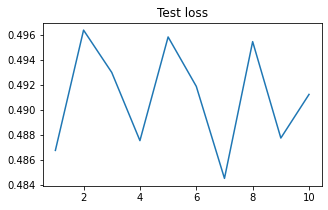

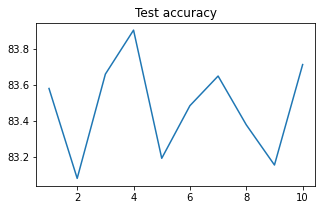

In [47]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 2 , batch size = 64 , Dropout  = 0, Epochs = 20

In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0)
        
        self.fc2 = nn.Linear(196, 98)
        self.fc2_drop = nn.Dropout(0)
        
        self.fc3 = nn.Linear(98, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0, inplace=False)
  (fc2): Linear(in_features=196, out_features=98, bias=True)
  (fc2_drop): Dropout(p=0, inplace=False)
  (fc3): Linear(in_features=98, out_features=47, bias=True)
)


In [49]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [50]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [51]:
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.857464
Train Epoch: 1 [12800/112800 (11%)]	Loss: 1.764480
Train Epoch: 1 [25600/112800 (23%)]	Loss: 1.188144
Train Epoch: 1 [38400/112800 (34%)]	Loss: 1.156149
Train Epoch: 1 [51200/112800 (45%)]	Loss: 1.048457
Train Epoch: 1 [64000/112800 (57%)]	Loss: 1.075997
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.976071
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.786764
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.632759

Test dataset: Average loss: 0.8057, Accuracy: 13967/18800 (74%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 0.930879
Train Epoch: 2 [12800/112800 (11%)]	Loss: 0.653557
Train Epoch: 2 [25600/112800 (23%)]	Loss: 0.567463
Train Epoch: 2 [38400/112800 (34%)]	Loss: 0.845147
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.820238
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.667399
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.566660
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.767883
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.517178

Test dataset: Average l

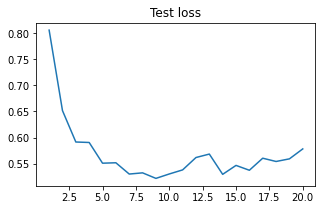

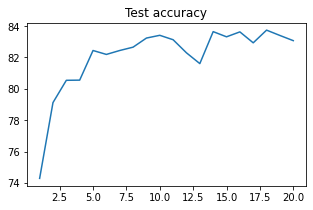

In [52]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 2 , batch size = 64 , Dropout  = 0, Epochs = 10

In [53]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 0.272289
Train Epoch: 1 [12800/112800 (11%)]	Loss: 0.224980
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.183441
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.245621
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.184094
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.220635
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.392904
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.347134
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.331301

Test dataset: Average loss: 0.5686, Accuracy: 15695/18800 (83%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 0.316851
Train Epoch: 2 [12800/112800 (11%)]	Loss: 0.204706
Train Epoch: 2 [25600/112800 (23%)]	Loss: 0.290227
Train Epoch: 2 [38400/112800 (34%)]	Loss: 0.550203
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.225308
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.225000
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.220792
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.220745
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.339517

Test dataset: Average l

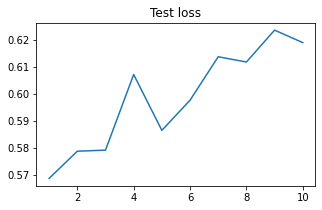

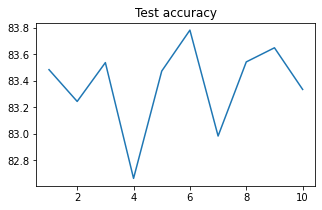

In [54]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 1 , batch size = 64 , Dropout  = 0.2, Epochs = 20



In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0.2)
        
        
        self.fc2 = nn.Linear(196, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        return F.log_softmax(self.fc2(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=196, out_features=47, bias=True)
)


In [56]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [57]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [58]:
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.846350
Train Epoch: 1 [12800/112800 (11%)]	Loss: 1.760771
Train Epoch: 1 [25600/112800 (23%)]	Loss: 1.314465
Train Epoch: 1 [38400/112800 (34%)]	Loss: 1.113534
Train Epoch: 1 [51200/112800 (45%)]	Loss: 1.194031
Train Epoch: 1 [64000/112800 (57%)]	Loss: 1.018255
Train Epoch: 1 [76800/112800 (68%)]	Loss: 1.141417
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.968726
Train Epoch: 1 [102400/112800 (91%)]	Loss: 1.130845

Test dataset: Average loss: 0.8572, Accuracy: 13959/18800 (74%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 1.050231
Train Epoch: 2 [12800/112800 (11%)]	Loss: 0.788778
Train Epoch: 2 [25600/112800 (23%)]	Loss: 1.028919
Train Epoch: 2 [38400/112800 (34%)]	Loss: 0.829804
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.573785
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.649471
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.797700
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.723385
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.790952

Test dataset: Average l

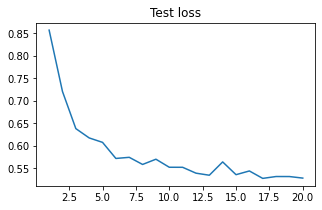

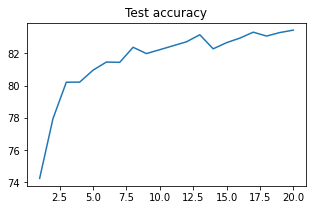

In [59]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 1 , batch size = 64 , Dropout  = 0.2, Epochs = 10



In [60]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 0.594115
Train Epoch: 1 [12800/112800 (11%)]	Loss: 0.688050
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.406837
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.391080
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.524535
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.361298
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.344804
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.483130
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.382412

Test dataset: Average loss: 0.5253, Accuracy: 15716/18800 (84%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 0.530091
Train Epoch: 2 [12800/112800 (11%)]	Loss: 0.443739
Train Epoch: 2 [25600/112800 (23%)]	Loss: 0.426247
Train Epoch: 2 [38400/112800 (34%)]	Loss: 0.524467
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.291843
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.314760
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.382332
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.370743
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.590224

Test dataset: Average l

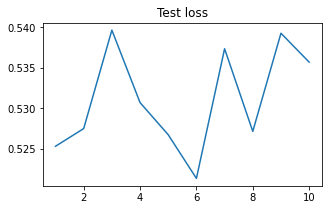

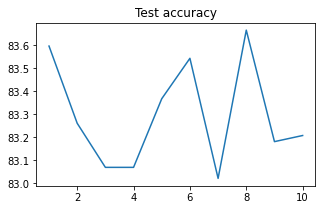

In [61]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 1 , batch size = 64 , Dropout  = 0, Epochs = 20


In [62]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 196)
        self.fc1_drop = nn.Dropout(0)
        
        
        self.fc2 = nn.Linear(196, 47)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        return F.log_softmax(self.fc2(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc1_drop): Dropout(p=0, inplace=False)
  (fc2): Linear(in_features=196, out_features=47, bias=True)
)


In [63]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [64]:
def test(loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        test_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest dataset: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [65]:
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 3.890158
Train Epoch: 1 [12800/112800 (11%)]	Loss: 1.400849
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.974333
Train Epoch: 1 [38400/112800 (34%)]	Loss: 1.072877
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.993172
Train Epoch: 1 [64000/112800 (57%)]	Loss: 1.292535
Train Epoch: 1 [76800/112800 (68%)]	Loss: 1.318907
Train Epoch: 1 [89600/112800 (79%)]	Loss: 1.052972
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.760416

Test dataset: Average loss: 0.8202, Accuracy: 14143/18800 (75%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 0.800752
Train Epoch: 2 [12800/112800 (11%)]	Loss: 0.517900
Train Epoch: 2 [25600/112800 (23%)]	Loss: 0.574186
Train Epoch: 2 [38400/112800 (34%)]	Loss: 0.632062
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.415454
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.786274
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.690537
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.715857
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.606636

Test dataset: Average l

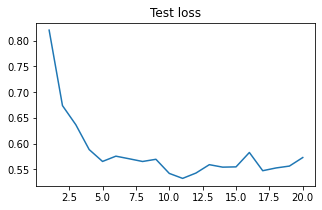

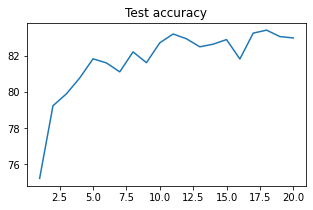

In [66]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');

# Hidden Layer = 1 , batch size = 64 , Dropout  = 0, Epochs = 10


In [67]:
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)

Train Epoch: 1 [0/112800 (0%)]	Loss: 0.331797
Train Epoch: 1 [12800/112800 (11%)]	Loss: 0.220376
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.277997
Train Epoch: 1 [38400/112800 (34%)]	Loss: 0.436367
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.332828
Train Epoch: 1 [64000/112800 (57%)]	Loss: 0.228523
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.509125
Train Epoch: 1 [89600/112800 (79%)]	Loss: 0.349347
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.285019

Test dataset: Average loss: 0.5645, Accuracy: 15574/18800 (83%)

Train Epoch: 2 [0/112800 (0%)]	Loss: 0.382320
Train Epoch: 2 [12800/112800 (11%)]	Loss: 0.216085
Train Epoch: 2 [25600/112800 (23%)]	Loss: 0.404142
Train Epoch: 2 [38400/112800 (34%)]	Loss: 0.371242
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.254764
Train Epoch: 2 [64000/112800 (57%)]	Loss: 0.273733
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.315864
Train Epoch: 2 [89600/112800 (79%)]	Loss: 0.344593
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.283499

Test dataset: Average l

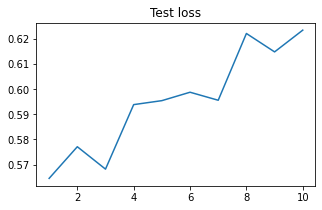

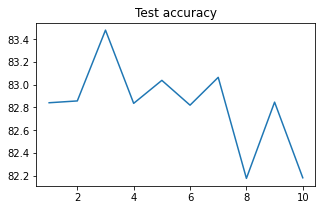

In [68]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('Test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('Test accuracy');